In [174]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [175]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

In [176]:
import roicat

This notebook is for visualization of the results of an ROICaT run. You can play with different inclusion criteria here, and also combine classification and tracking results to view the intersection of the two.

In [179]:
use_classificationResults = False
subject = 'SP058'
fov_name = 'FOV_04'

dir_save = Path('G:/Shared drives/WG-Mesoscope/Chronic/'+subject+'/allROIs').resolve()
name_save = fov_name


results = roicat.helpers.pickle_load(
    filepath=str(dir_save / (name_save + '.ROICaT.tracking.results' + '.pkl')),
    zipCompressed=False,
)

rundata = roicat.helpers.pickle_load(
    filepath=str(dir_save / (name_save + '.ROICaT.tracking.rundata' + '.pkl')),
    zipCompressed=False,
)

if use_classificationResults:
    results_classification = roicat.helpers.pickle_load(
        filepath=str(dir_save / (name_save + '.ROICaT.classification_drawn.results' + '.pkl')),
    )
else:
    results_classification = None

In [180]:
## List all available quality metrics
print('Available quality metrics:')
display(results['quality_metrics'])

Available quality metrics:


{'cluster_labels_unique': array([  -1,    0,    1, ..., 3658, 3659, 3660], dtype=int64),
 'cluster_intra_means': array([2.35388366e-04, 6.23490810e-01, 4.34849735e-01, ...,
        8.97565079e-01, 8.78643036e-01, 9.17488575e-01]),
 'cluster_intra_mins': array([0.0000000e+00, 5.7273316e-01, 4.7683716e-07, ..., 7.0117354e-01,
        6.5620196e-01, 8.9538717e-01], dtype=float32),
 'cluster_intra_maxs': array([0.98731411, 0.67424846, 0.95656306, ..., 0.96639448, 0.96866226,
        0.94503009]),
 'cluster_silhouette': array([-0.99975805,  0.14319197, -0.33219995, ..., -0.02967014,
        -0.04978593,  0.04432666]),
 'sample_silhouette': array([ 0.94062493,  0.94149798,  0.85688674, ...,  0.79544347,
        -0.90694107, -0.93092497]),
 'hdbscan': {'sample_outlierScores': array([0.        , 0.04663817, 0.        , ..., 0.0014333 , 0.        ,
         0.04296191]),
  'sample_probabilities': array([1.       , 1.       , 1.       , ..., 0.9985667, 0.       ,
         0.       ])},
 'sequent

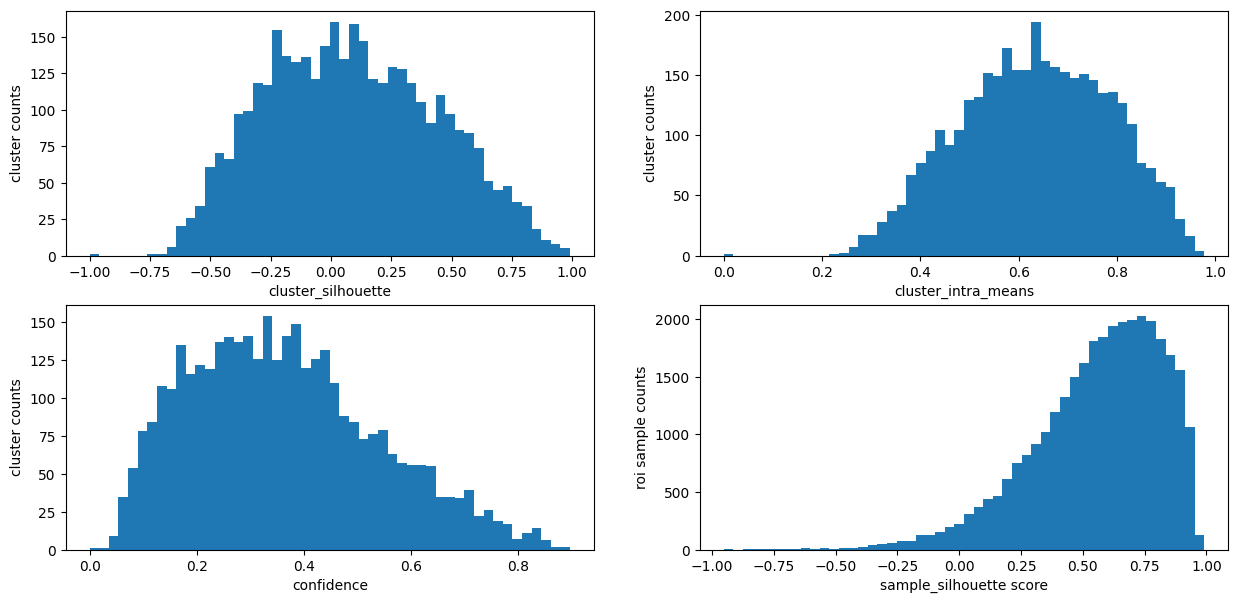

In [181]:
## Plot the distribution of the quality metrics
confidence = (((results['quality_metrics']['cluster_silhouette'] + 1) / 2) * results['quality_metrics']['cluster_intra_means'])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,7))

axs[0,0].hist(results['quality_metrics']['cluster_silhouette'], 50);
axs[0,0].set_xlabel('cluster_silhouette');
axs[0,0].set_ylabel('cluster counts');

axs[0,1].hist(results['quality_metrics']['cluster_intra_means'], 50);
axs[0,1].set_xlabel('cluster_intra_means');
axs[0,1].set_ylabel('cluster counts');

axs[1,0].hist(confidence, 50);
axs[1,0].set_xlabel('confidence');
axs[1,0].set_ylabel('cluster counts');

#axs[1,1].hist(results['quality_metrics']['sample_silhouette'], 50);
axs[1,1].hist(results['quality_metrics']['sample_silhouette'][results['clusters']['labels']!=-1], 50);
axs[1,1].set_xlabel('sample_silhouette score');
axs[1,1].set_ylabel('roi sample counts');

fig.savefig(dir_save / (fov_name + '_QualityMetrics' + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_QualityMetrics' + '.png'),bbox_inches='tight')

c:\users\samuel\documents\github\roicat\roicat\visualization.py:241: RuntimeWarning: divide by zero encountered in divide
  rois = rois.multiply(1.0/rois.max(1).A).power(1)



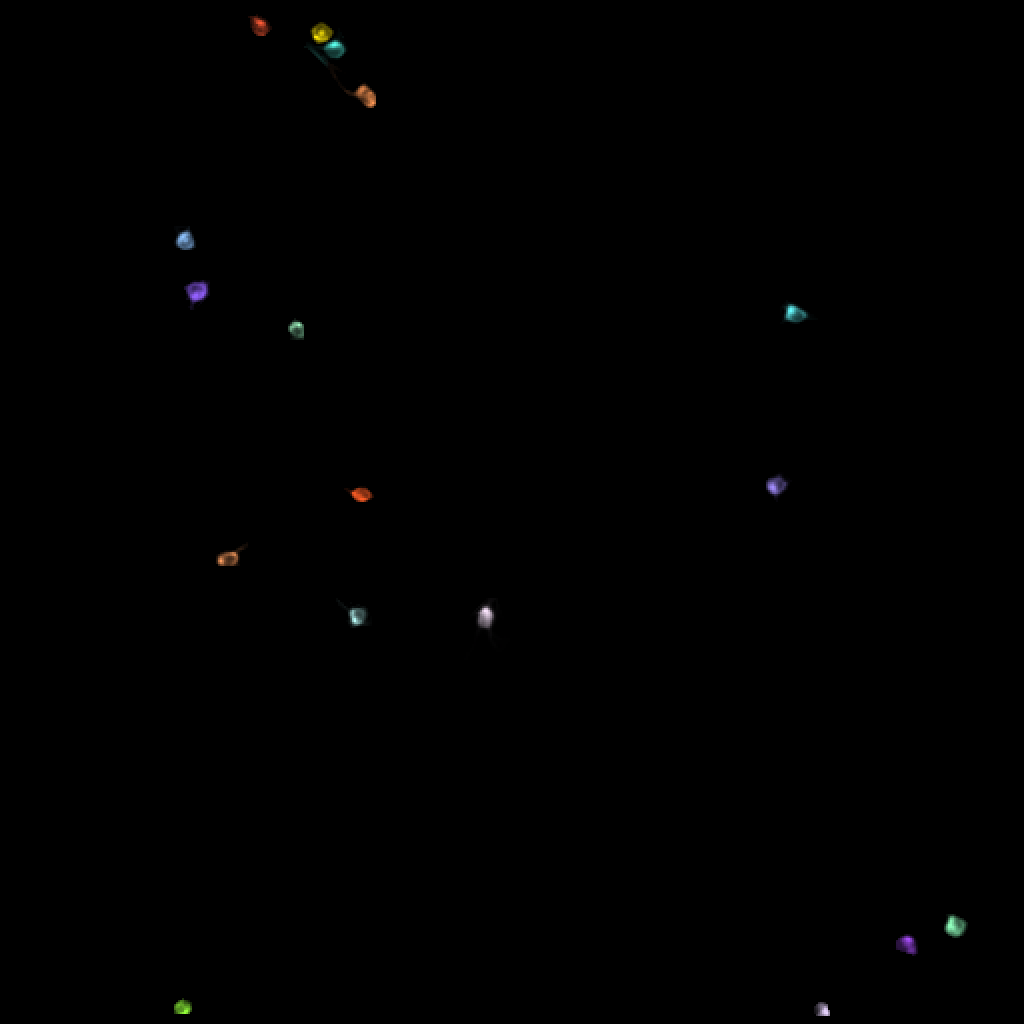

In [182]:
labels = [c*t - (np.logical_not(c)) for c,t in zip(results_classification['preds'], results['clusters']['labels_bySession'])] if use_classificationResults else results['clusters']['labels_bySession']

FOVs_colored = roicat.visualization.compute_colored_FOV(
    labels = results['clusters']['labels'],
    spatialFootprints = results['ROIs']['ROIs_aligned'], 
    FOV_height = results['ROIs']['frame_height'], 
    FOV_width = results['ROIs']['frame_width'], 
    alphas_sf = (results['quality_metrics']['sample_silhouette'] > -1), ## SET INCLUSION CRITERIA FOR ROI SAMPLES
    alphas_labels = (results['quality_metrics']['cluster_silhouette'] > 0.7) * (results['quality_metrics']['cluster_intra_means'] > 0.9),   ## SET INCLUSION CRITERIA FOR CLUSTERS/LABELS
)

roicat.visualization.display_toggle_image_stack(FOVs_colored, image_size=2)

In [183]:
#load iscell arrays 
from pathlib import Path
paths_allStat = results['input_data']['paths_stat']
paths_allIscell = list(np.unique([(Path(path) / '..' / 'iscell.npy').resolve() for path in paths_allStat]))
iscell_byS = [np.load(path)[:,0] for path in paths_allIscell]
iscell_all = np.concatenate(iscell_byS)

In [466]:
#select clusters to plot
ucids = np.array(results['clusters']['labels'])
ucids_unique, ucids_inv, ucids_counts = np.unique(ucids[ucids>=0], return_inverse=True, return_counts=True)

ucids_num_iscell = np.array([sum(iscell_all[ucids>=0][ucids_inv==i]) for i in ucids_unique])
#ucids_qc = results['quality_metrics']['cluster_silhouette'][1:] #all except the '-1' cluster
ucids_qc = confidence[1:]

#cluster selection criteria: 
#1) cluster should be present in at least half of all sessions
#2) cluster should be classified as a cell in at least half the sessions where it appears
#3) cluster confidence score should be at least 0.2
idx_sel = (ucids_counts>=len(results['clusters']['labels_bySession'])*0.5) * (ucids_num_iscell>=ucids_counts*0.5) * (confidence[1:]>=0)

ucids_unique = ucids_unique[idx_sel]
ucids_counts = ucids_counts[idx_sel]
ucids_num_iscell = ucids_num_iscell[idx_sel]
ucids_qc = ucids_qc[idx_sel]

#sorting critera
#ucids_unique = ucids_unique[np.argsort(-ucids_counts)] #sort by nr of days
ucids_unique = ucids_unique[np.argsort(-ucids_qc)] #sort by qc


print(f'Total number of clusters: {len(np.unique(results["clusters"]["labels"]))-1}')
print(f'Number of clusters selected: {len(ucids_unique)}')

Total number of clusters: 3661
Number of clusters selected: 670


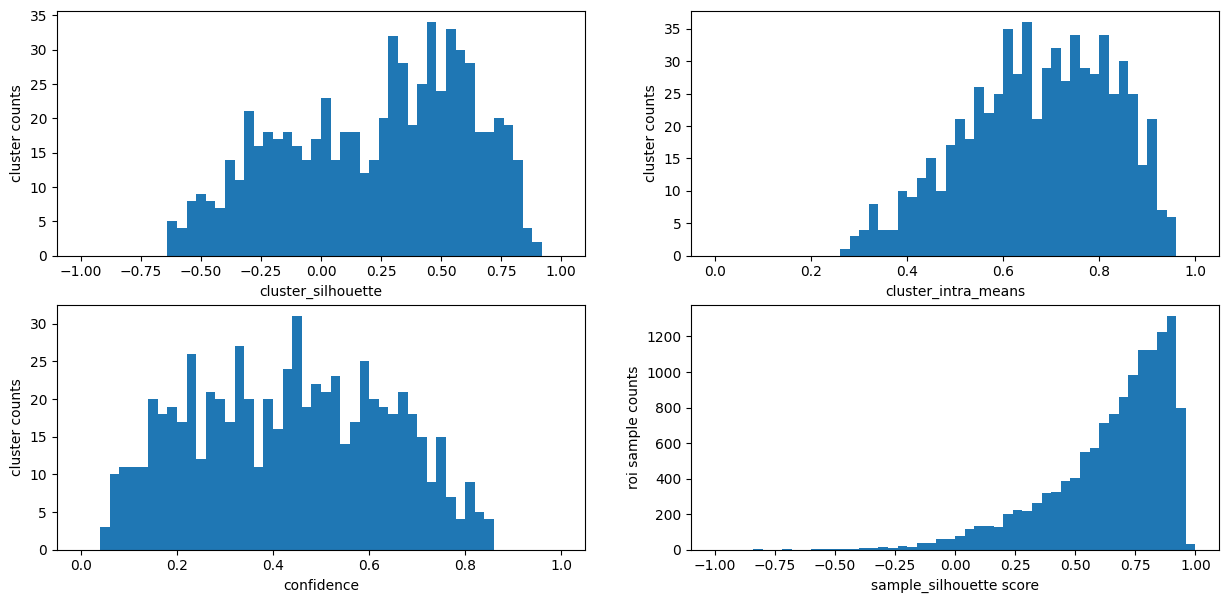

In [360]:
## Plot the distribution of the quality metrics after selection
confidence = (((results['quality_metrics']['cluster_silhouette'] + 1) / 2) * results['quality_metrics']['cluster_intra_means'])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,7))

axs[0,0].hist(results['quality_metrics']['cluster_silhouette'][np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)], np.linspace(-1,1,51));
axs[0,0].set_xlabel('cluster_silhouette');
axs[0,0].set_ylabel('cluster counts');

axs[0,1].hist(results['quality_metrics']['cluster_intra_means'][np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)], np.linspace(0,1,51));
axs[0,1].set_xlabel('cluster_intra_means');
axs[0,1].set_ylabel('cluster counts');

axs[1,0].hist(confidence[np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)], np.linspace(0,1,51));
axs[1,0].set_xlabel('confidence');
axs[1,0].set_ylabel('cluster counts');

#axs[1,1].hist(results['quality_metrics']['sample_silhouette'], 50);
axs[1,1].hist(results['quality_metrics']['sample_silhouette'][np.isin(results['clusters']['labels'],ucids_unique)], np.linspace(-1,1,51));
axs[1,1].set_xlabel('sample_silhouette score');
axs[1,1].set_ylabel('roi sample counts');

fig.savefig(dir_save / (fov_name + '_sel_QualityMetrics' + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_sel_QualityMetrics' + '.png'),bbox_inches='tight')

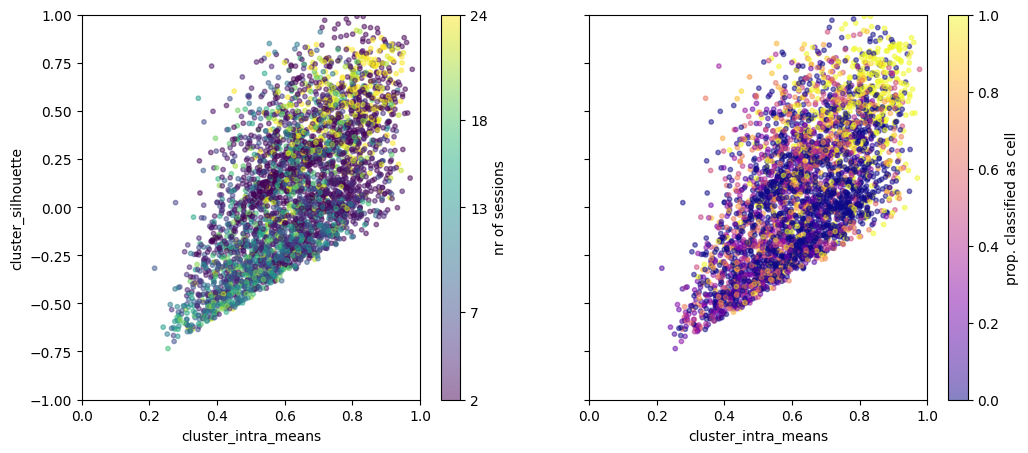

In [358]:
# check for relationships between various quality metrics
#fig = plt.figure(figsize=(4,3))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)

im1 = axs[0].scatter(results['quality_metrics']['cluster_intra_means'][np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)],
                 results['quality_metrics']['cluster_silhouette'][np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)],10, c=ucids_counts, alpha=0.5);
axs[0].set_xlabel('cluster_intra_means');
axs[0].set_ylabel('cluster_silhouette');
axs[0].set_xlim(0,1)
axs[0].set_ylim(-1,1)

fig.colorbar(im1, ax=axs[0], ticks=np.linspace(min(ucids_counts),max(ucids_counts),5).astype(int), label='nr of sessions')

im2 = axs[1].scatter(results['quality_metrics']['cluster_intra_means'][np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)],
                 results['quality_metrics']['cluster_silhouette'][np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)],10, c=(ucids_num_iscell/ucids_counts), alpha=0.5, cmap='plasma');
axs[1].set_xlabel('cluster_intra_means');
#axs[1].set_ylabel('cluster_silhouette');
axs[1].set_xlim(0,1)
axs[1].set_ylim(-1,1)

fig.colorbar(im2, ax=axs[1], label='prop. classified as cell')


plt.show()

fig.savefig(dir_save / (fov_name + '_all_QualityMetrics_scatter' + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_all_QualityMetrics_scatter' + '.png'),bbox_inches='tight')

In [206]:
def crop_cluster_im_square(im: np.ndarray, center: np.ndarray, sz: int=25) -> np.ndarray:
    """
    Crops the image to a square of fixed size, centered around its center-of-mass. 
    SP 2024

    Args:
        im (np.ndarray):  
            Image to crop. (shape: *(H, W)*) 
        center (np.ndarray):
            center coords y, x (shape: (2))
        sz (int):
            width/height of square in pixels

    Returns:
        (np.ndarray): 
            im_out (np.ndarray): 
                Cropped image. (shape: *(sz, sz)*) 
    """
    from scipy.ndimage import center_of_mass

    if sz % 2 == 0:
        sz_odd = sz-1
    else:
        sz_odd = sz

    if np.all(np.isnan(im)) or np.all(im==0):
        im_out = np.zeros((sz,sz))
    else:
        com_y = center[0]
        com_x = center[1]
        # Define edges of cropping square
        y_min = max(0, int(com_y) - (sz_odd+1) // 2)
        x_min = max(0, int(com_x) - (sz_odd+1) // 2)
        y_max = min(im.shape[0], int(com_y) + (sz_odd+1) // 2)
        x_max = min(im.shape[1], int(com_x) + (sz_odd+1) // 2)
        # Crop the image
        im_out = im[y_min:y_max, x_min:x_max]

    # If the cropped region is smaller than the requested size, pad it
    pad_y = sz - im_out.shape[0]
    pad_x = sz - im_out.shape[1]
    #print(pad_y)
    #print(pad_x)
    #if pad_y > 0 or pad_x > 0:
    #    im_out = np.pad(im_out, ((pad_y,0), (pad_x,0)), mode='constant', constant_values=0)

    return im_out


In [207]:
sampleSilhouette_bySession = []
cnt = 0
for i in np.arange(len(results['clusters']['labels_bySession'])):
    sampleSilhouette_bySession.append(results['quality_metrics']['sample_silhouette'][cnt+np.arange(len(results['clusters']['labels_bySession'][i]))])
    cnt += len(results['clusters']['labels_bySession'][i])

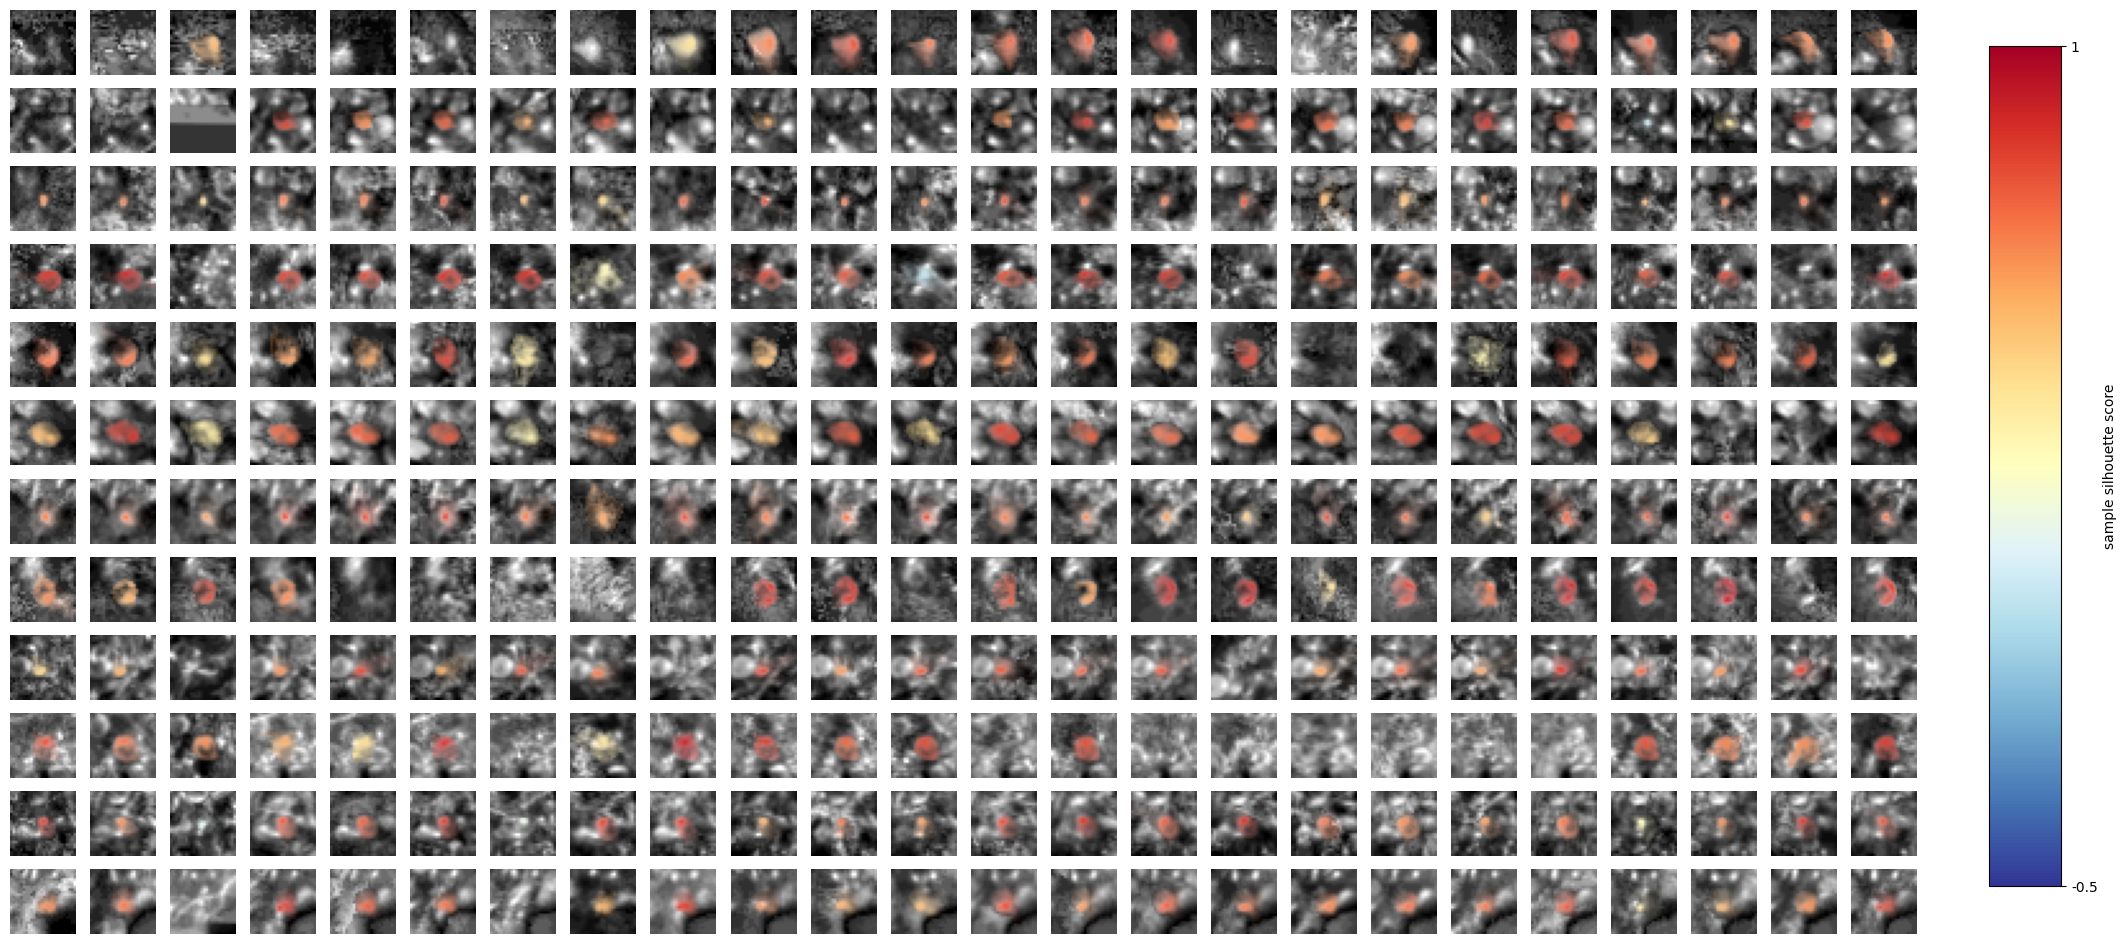

In [236]:
#plot ucids_unique using Samuel's visualization method (grid with cropped mean images and masks)

from scipy.ndimage import center_of_mass
from matplotlib import colormaps
from matplotlib.colors import Normalize

n_labels_to_display = 12

suff = '_conf_mid' #for saving the figures

add_all_masks = False

#exclude_bySession = [~np.array(iscell, dtype=bool) for iscell in iscell_byS] #exclude the ROIs that are not classified as cells
exclude_bySession = [s<0.0 for s in sampleSilhouette_bySession] #exclude the ROIs that have small sample_silhouette scores

color_by_QC = True #if false, will instead color by inclusion/exclusion criteria above
qc_bySession = sampleSilhouette_bySession
qc_label = 'sample silhouette score' #for colorbar labelling
cmap = colormaps.get_cmap('RdYlBu_r')
vmin = -0.5
vmax = 1

norm = Normalize(vmin=vmin, vmax=vmax) #select the range of QC expected here

meanImgs = rundata['aligner']['ims_registered_nonrigid']
meanImgs_masks = [rois[labs>-1].max(0).toarray().reshape(results['ROIs']['frame_height'], results['ROIs']['frame_height']) for (rois,labs) in zip(results['ROIs']['ROIs_aligned'],results['clusters']['labels_bySession'])]

ROI_ims_sparse = scipy.sparse.vstack(results['ROIs']['ROIs_aligned'])
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()

labels_bool_t = scipy.sparse.vstack([scipy.sparse.csr_matrix(np.array(results['clusters']['labels'])==u) for u in ucids_unique]).tocsr()
labels_bool_t = labels_bool_t[:n_labels_to_display]

fig, axs = plt.subplots(n_labels_to_display,len(meanImgs),figsize=(len(meanImgs),n_labels_to_display))
for i,lab in enumerate(labels_bool_t):
    idx = lab.indices
    com_y, com_x = center_of_mass(np.array(ROI_ims_sparse[idx].mean(axis=0).reshape(results['ROIs']['frame_height'], results['ROIs']['frame_width'])))
    cnt = 0
    for j in np.arange(len(meanImgs)):
        mIm = crop_cluster_im_square(meanImgs[j],np.array([com_y, com_x]))
        mIm_mask = crop_cluster_im_square(meanImgs_masks[j],np.array([com_y, com_x]))
        mIm_mask_alpha = 0.5 * ((mIm_mask - mIm_mask.min()) / (mIm_mask.max() - mIm_mask.min())+1e-8)
        green_overlay = np.zeros((mIm_mask.shape[0], mIm_mask.shape[1], 4))  # RGBA image
        green_overlay[..., 1] = 1.0  # Green channel to maximum
        green_overlay[..., 3] = mIm_mask_alpha    
        axs[i,j].imshow(mIm, cmap='gray')
        if add_all_masks:
            axs[i,j].imshow(green_overlay)  #all other ROI masks
        col_overlay = np.zeros((mIm.shape[0], mIm.shape[1], 4))  # RGBA image
        if np.isin(ucids_unique[i],results['clusters']['labels_bySession'][j]):
            im = ROI_ims_sparse[idx[cnt]].toarray().reshape(results['ROIs']['frame_height'], results['ROIs']['frame_width'])
            im = crop_cluster_im_square(im,np.array([com_y, com_x]))
            im_alpha = 0.9 * ((im - im.min()) / (im.max() - im.min())+1e-8)
            if color_by_QC:
                col_overlay = np.full((mIm.shape[0], mIm.shape[1], 4),cmap(norm(qc_bySession[j][results['clusters']['labels_bySession'][j]==ucids_unique[i]])))
            else:
                if exclude_bySession[j][results['clusters']['labels_bySession'][j]==ucids_unique[i]]:
                    col_overlay[..., 2] = 1.0  # Blue channel to maximum if this was not classified as a cell
                else:
                    col_overlay[..., 0] = 1.0  # Red channel to maximum if this was classified as a cell
            col_overlay[..., 3] = im_alpha          
            cnt += 1
        im = axs[i,j].imshow(col_overlay) 
        #axs[i,j].imshow(im, cmap='gray')
        axs[i,j].axis("off")

fig.subplots_adjust(right=0.92)
dummy_ax = fig.add_axes([0.95, 0.1, 0.03, 0.7])
cbar_im = plt.imshow(np.array([[0,1]]), cmap=cmap)
plt.gca().set_visible(False)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
cbar = plt.colorbar(orientation="vertical", cax = cbar_ax, ticks=[0,1], label=qc_label)
cbar_ax.set_yticklabels([vmin, vmax]);

fig.savefig(dir_save / (fov_name + '_clustersBySession' + suff + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_clustersBySession' + suff + '.png'),bbox_inches='tight')

In [ ]:
#plot ucids_unique using roicat's standard vizualization

ROI_ims_sparse = scipy.sparse.vstack(results['ROIs']['ROIs_aligned'])
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()

ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(roicat.visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), results['ROIs']['frame_height'], results['ROIs']['frame_width']))), axis=1) )

for ii in range(min(len(ucid_sfCat), 12)):
    plt.figure(figsize=(40,1))
    plt.imshow(ucid_sfCat[ii], cmap='gray')
    plt.axis('off')

C:\Users\Samuel\AppData\Local\Temp\ipykernel_16976\973002061.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  qc_fullMat[i,j] = qc_bySession[j][labs==ucid]


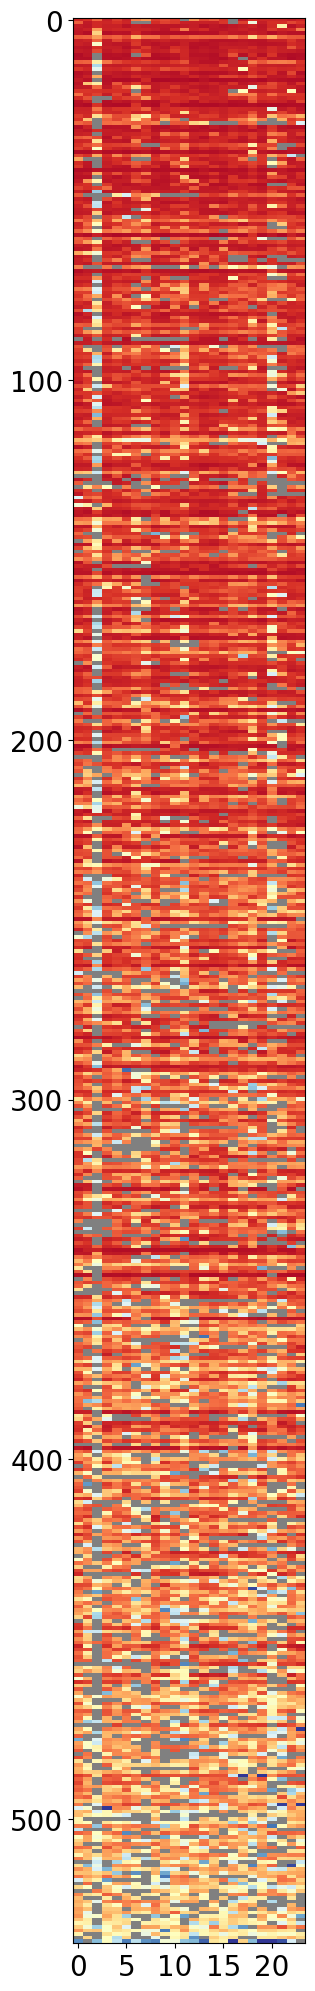

In [308]:
#plot the full matrix of clusters-by-day, color coded by QC
qc_bySession = sampleSilhouette_bySession
qc_label = 'sample silhouette score' #for colorbar labelling
cmap = colormaps.get_cmap('RdYlBu_r')
cmap.set_bad('gray')

suff = '_ss'

#vmin = -0.5
#vmax = 1

qc_fullMat = np.empty((len(ucids_unique),len(meanImgs)))
qc_fullMat[:] = np.nan
lbS = results['clusters']['labels_bySession']

for i, ucid in enumerate(ucids_unique):
    for j, labs in enumerate(lbS):
        if np.isin(ucid,labs):
            qc_fullMat[i,j] = qc_bySession[j][labs==ucid]

fig = plt.figure(figsize=(3,25))
plt.imshow(qc_fullMat, interpolation=None, aspect='auto', cmap = cmap, vmin=vmin, vmax=vmax) 
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

fig.savefig(dir_save / (fov_name + '_clusterMatrix' + suff + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_clusterMatrix' + suff + '.png'),bbox_inches='tight')

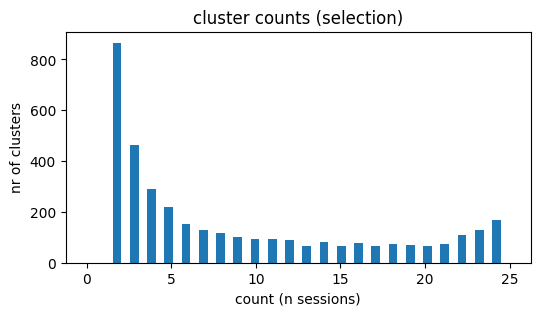

In [331]:
# %matplotlib widget

ucids = np.array(results['clusters']['labels'])
_, counts = np.unique(ucids, return_counts=True)

n_sessions = len(results['clusters']['labels_bySession'])
fig = plt.figure(figsize=(6,3))
plt.hist(counts, bins=n_sessions*2 + 1, range=(0, n_sessions+1));

plt.xlabel('count (n sessions)');
plt.ylabel('nr of clusters');
plt.title('cluster counts (selection)');

fig.savefig(dir_save / (fov_name + '_clusterCounts' + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_clusterCounts' + '.png'),bbox_inches='tight')

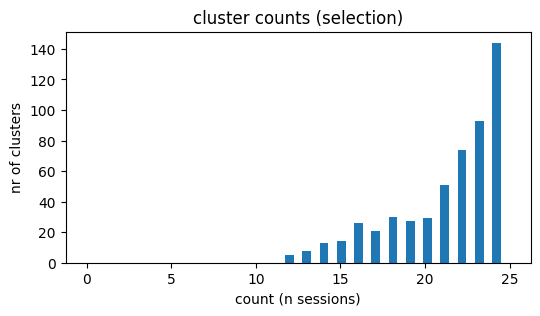

In [332]:
ucids = np.array(results['clusters']['labels'])
_, counts_sel = np.unique(ucids[np.isin(ucids,ucids_unique)], return_counts=True)

n_sessions = len(results['clusters']['labels_bySession'])
fig = plt.figure(figsize=(6,3))
plt.hist(counts_sel, bins=n_sessions*2 + 1, range=(0, n_sessions+1));

plt.xlabel('count (n sessions)')
plt.ylabel('nr of clusters')
plt.title('cluster counts (selection)');

fig.savefig(dir_save / (fov_name + '_clusterCounts' + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_clusterCounts' + '.png'),bbox_inches='tight')

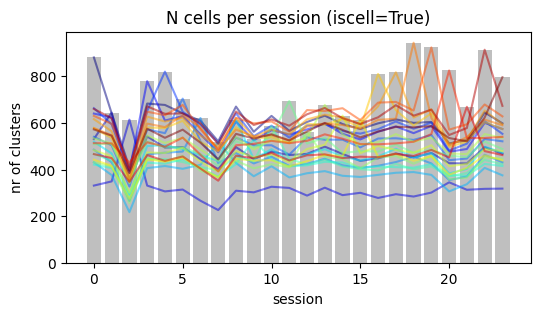

In [433]:
suff = '_iscell'

ucids = np.array(results['clusters']['labels'])
lbS = results['clusters']['labels_bySession']
n_sessions = len(lbS)

nClusters_perSession = [np.sum((l>-1) * (np.array(iscell,dtype='bool'))) for l,iscell in zip(lbS,iscell_byS)]
fig = plt.figure(figsize=(6,3))
#plt.bar(np.arange(n_sessions),nClusters_perSession, color='gray', alpha=0.5)
plt.bar(np.arange(n_sessions),[sum(c) for c in iscell_byS], color='gray', alpha=0.5)

plt.ylabel('nr of clusters')
plt.xlabel('session')
plt.title('N cells per session (iscell=True)');

colors = plt.cm.jet(np.linspace(0,1,len(lbS)))
#fig2 = plt.figure(figsize=(6,3))
for i, labs in enumerate(lbS):
    #ucids_thisSession = labs[np.isin(labs,np.unique(ucids[ucids>=0])) * np.array(iscell_byS[i],dtype='bool')]
    ucids_thisSession = labs[np.array(iscell_byS[i],dtype='bool')]
    #plt.plot(np.arange(len(lbS)),[np.sum(np.isin(l,ucids_thisSession)) for l in lbS], color=colors[i], alpha=0.5)
    numPerSess = [np.sum(np.isin(l,ucids_thisSession[ucids_thisSession>=0])) for l in lbS]
    numPerSess[i] = sum(iscell_byS[i])
    plt.plot(np.arange(len(lbS)),numPerSess, color=colors[i], alpha=0.5)
plt.show()

fig.savefig(dir_save / (fov_name + '_nClusters_perSession' + suff + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_nClusters_perSession' + suff + '.png'),bbox_inches='tight')

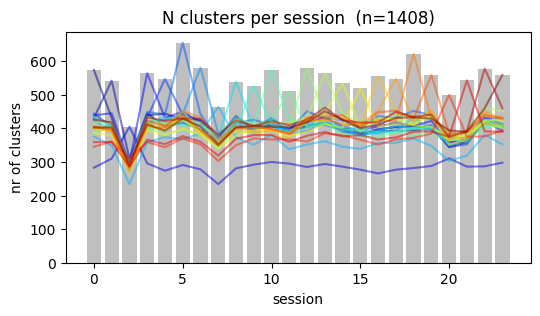

In [434]:
#select clusters to plot
#ucids = np.array(results['clusters']['labels'])
#ucids_unique, ucids_inv, ucids_counts = np.unique(ucids[ucids>=0], return_inverse=True, return_counts=True)

#ucids_num_iscell = np.array([sum(iscell_all[ucids>=0][ucids_inv==i]) for i in ucids_unique])
#ucids_qc = results['quality_metrics']['cluster_silhouette'][1:] #all except the '-1' cluster
#ucids_qc = confidence[1:]

#selection criteria
#idx_sel = (ucids_counts>=12) * (ucids_num_iscell>=12) #* (ucids_qc<0.5)

#ucids_unique = ucids_unique[idx_sel]

lbS = results['clusters']['labels_bySession']
n_sessions = len(lbS)

suff = '_sel'

nClusters_perSession = [np.sum(np.isin(l,ucids_unique)) for l in lbS]
fig = plt.figure(figsize=(6,3))
plt.bar(np.arange(n_sessions),nClusters_perSession, color='gray', alpha=0.5)

plt.ylabel('nr of clusters')
plt.xlabel('session')
plt.title("N clusters per session  (n="+str(len(ucids_unique))+")");

colors = plt.cm.jet(np.linspace(0,1,len(lbS)))
#fig2 = plt.figure(figsize=(6,3))
for i, labs in enumerate(lbS):
    ucids_thisSession = labs[np.isin(labs,ucids_unique)]
    plt.plot(np.arange(len(lbS)),[np.sum(np.isin(l,ucids_thisSession)) for l in lbS], color=colors[i], alpha=0.5)

plt.show()

#fig.savefig(dir_save / (fov_name + '_nClusters_perSession' + suff + '.svg'),bbox_inches='tight')
#fig.savefig(dir_save / (fov_name + '_nClusters_perSession' + suff + '.png'),bbox_inches='tight')

In [403]:
len(ucids_unique)

670

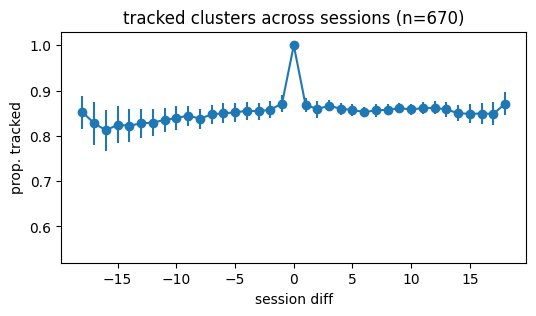

In [474]:
#plot showing the average proportion of clusters shared before and after a given day
import scipy.stats as st

suff = '_sel'

propShared_aroundSess = np.empty((len(lbS),2*len(lbS)-1))
propShared_aroundSess[:] = np.nan
iMid = len(lbS)-1

for i, labs in enumerate(lbS):
    ucids_thisSession = labs[np.isin(labs,ucids_unique)]
    vals = np.array([np.sum(np.isin(l,ucids_thisSession)) for l in lbS])/len(ucids_thisSession)
    propShared_aroundSess[i,len(lbS)-i-1+np.arange(len(lbS))] = vals

data = propShared_aroundSess
x = np.arange(-len(lbS)+1,len(lbS))
y = np.nanmean(propShared_aroundSess,axis=0)
err = st.sem(propShared_aroundSess,axis=0,nan_policy='omit')
#[l,u] = st.t.interval(0.90, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
cutoff = 5

#plt.ylim(0,520)
plt.figure(figsize=(6,3))
plt.errorbar(x[cutoff:-cutoff], y[cutoff:-cutoff], yerr=err[cutoff:-cutoff], fmt='-o')
plt.xlabel('session diff')
plt.ylabel('prop. tracked')
plt.title("tracked clusters across sessions (n="+str(len(ucids_unique))+")")
plt.gca().set_ylim(0.52, 1.03)

plt.gcf().savefig(dir_save / (fov_name + '_propClusters_tracked' + suff + '.svg'),bbox_inches='tight')
plt.gcf().savefig(dir_save / (fov_name + '_propClusters_tracked' + suff + '.png'),bbox_inches='tight')

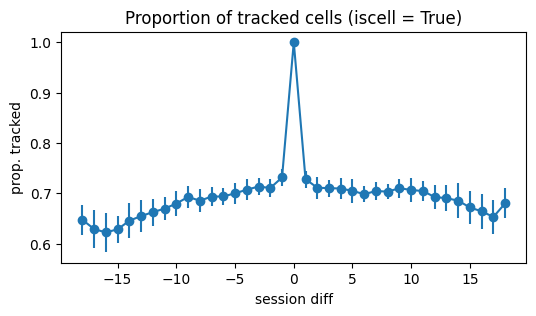

In [422]:
#plot showing the average proportion of clusters shared before and after a given day (only for ROIs with iscell=True)
import scipy.stats as st

suff = '_iscell'

ucids = np.array(results['clusters']['labels'])
lbS = results['clusters']['labels_bySession']

propShared_aroundSess = np.empty((len(lbS),2*len(lbS)-1))
propShared_aroundSess[:] = np.nan
iMid = len(lbS)-1

for i, labs in enumerate(lbS):
    #ucids_thisSession = labs[np.isin(labs,np.unique(ucids[ucids>=0])) * np.array(iscell_byS[i],dtype='bool')]
    ucids_thisSession = labs[np.array(iscell_byS[i],dtype='bool')]
    vals = np.array([np.sum(np.isin(l,ucids_thisSession[ucids_thisSession>=0])) for l in lbS])/len(ucids_thisSession)
    vals[i] = 1 #make sure ref value is 1
    propShared_aroundSess[i,len(lbS)-i-1+np.arange(len(lbS))] = vals

data = propShared_aroundSess
x = np.arange(-len(lbS)+1,len(lbS))
y = np.nanmean(propShared_aroundSess,axis=0)
err = st.sem(propShared_aroundSess,axis=0,nan_policy='omit')
#[l,u] = st.t.interval(0.90, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
cutoff = 5

#plt.ylim(0,520)
plt.figure(figsize=(6,3))
plt.errorbar(x[cutoff:-cutoff], y[cutoff:-cutoff], yerr=err[cutoff:-cutoff], fmt='-o')
plt.xlabel('session diff')
plt.ylabel('prop. tracked')
plt.title("Proportion of tracked cells (iscell = True)");

plt.gcf().savefig(dir_save / (fov_name + '_propCells_tracked' + suff + '.svg'),bbox_inches='tight')
plt.gcf().savefig(dir_save / (fov_name + '_propCells_tracked' + suff + '.png'),bbox_inches='tight')

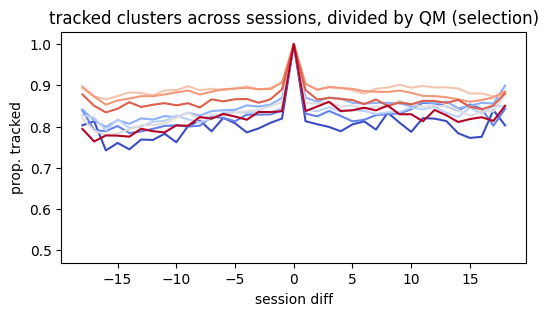

In [472]:
#plot showing the average proportion of clusters shared before and after a given day, separated by cluster QM
import scipy.stats as st

uniqueLabels = np.unique(np.array(results['clusters']['labels']))
uniqueLabels = uniqueLabels[uniqueLabels>=0]
qc_perLabel = (((results['quality_metrics']['cluster_silhouette'] + 1) / 2) * results['quality_metrics']['cluster_intra_means']) #confidence
#qc_perLabel = results['quality_metrics']['cluster_silhouette']
qc_perLabel = qc_perLabel[1:] 

uniqueLabels = ucids_unique
qc_perLabel = ucids_qc

suff = '_sel_qc'

plt.figure(figsize=(6,3))
import math
qm_mins = np.arange(math.floor(min(qc_perLabel) * 10)/10.0,math.ceil(max(qc_perLabel) * 10)/10.0,0.1)
qm_maxs = qm_mins+0.1
colors = plt.cm.coolwarm(np.linspace(0,1,len(qm_mins)))
cnt = 0

for qmin, qmax in zip(qm_mins,qm_maxs):
    
    propShared_aroundSess = np.empty((len(lbS),2*len(lbS)-1))
    propShared_aroundSess[:] = np.nan
    iMid = len(lbS)-1
    
    for i, labs in enumerate(lbS):
        ucids_thisSession = labs[np.isin(labs,uniqueLabels[(qc_perLabel>qmin)*(qc_perLabel<=qmax)])]
        vals = np.array([np.sum(np.isin(l,ucids_thisSession)) for l in lbS])/len(ucids_thisSession)
        propShared_aroundSess[i,len(lbS)-i-1+np.arange(len(lbS))] = vals
    
    data = propShared_aroundSess
    x = np.arange(-len(lbS)+1,len(lbS))
    y = np.nanmean(propShared_aroundSess,axis=0)
    #err = st.sem(propShared_aroundSess,axis=0,nan_policy='omit')
    #[l,u] = st.t.interval(0.90, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
    cutoff = 5
    
    #plt.ylim(0,520)
    
    #plt.errorbar(x[cutoff:-cutoff], y[cutoff:-cutoff], yerr=err[cutoff:-cutoff], fmt='-o')
    plt.plot(x[cutoff:-cutoff], y[cutoff:-cutoff], color=colors[cnt])
    #if cnt==0 or cnt==len(qm_mins)-1:
    #    plt.text(x[-cutoff], y[-cutoff], "{:.1f}".format(qmin)+"-"+"{:.1f}".format(qmax), color=colors[cnt])
    
    cnt += 1

plt.xlabel('session diff')
plt.ylabel('prop. tracked')
plt.gca().set_ylim(0.47,1.03)
plt.title("tracked clusters across sessions, divided by QM (selection)");

plt.gcf().savefig(dir_save / (fov_name + '_propClusters_tracked' + suff + '.svg'),bbox_inches='tight')
plt.gcf().savefig(dir_save / (fov_name + '_propClusters_tracked' + suff + '.png'),bbox_inches='tight')